# **Natural Language Processing Final Project**


# Hate Speech Detection

## In this notebook, we implement a model for hate speech detection, specifically for the ***Amharic language***. 
## When building this project, we encountered a lack of a dataset to train our model to its best. However, we obtained some data collected by a Ph.D. student from Bahir Dar University and some data from Hugging Face. In addition to that, we implemented the best model by merging that data into one cohesive dataset.

# We deployed the model on Amazon Web Services (AWS), and the user interface of the project was implemented using React and hosted on Vercel.

### Here is a fully functional model with a user interface: [Amharic Hate Speech Detector](https://amharic-hate-detection.vercel.app/).

## We have done in group of two.

|   **Name**             |   **ID**       |
    ----------                 |--------
| Felmeta Muktar     | UGR/3555/12   |
|  Usmael Abdurhaman  | UGR/6575/12   |

# Let's begin by importing essential libraries 

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import plotly.express as px
import nltk 
import tensorflow as tf

# Importing Keras modules
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.activations import *

# Importing TensorFlow modules
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten, Dropout,LSTM
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# Importing Gensim modules
from gensim.models import Word2Vec

# Importing scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Reading the datasets

In [2]:
# Reading datasets and assigning the names post and labels to it and
# Removing extra white space from labels
posts_data = pd.read_csv("/kaggle/input/amharic/updated_posts.txt", header=None)
labels_data = pd.read_csv("/kaggle/input/amharic/updated_labels.txt", header=None)
posts_data.columns = ['post']
labels_data.columns = ['labels']
labels_data = labels_data['labels'].str.strip(' ')  
posts_data['post'] = posts_data['post'].str.replace('@USER', '', regex=False)

In [3]:
posts_data.head()

,post
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...
1,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደ...
2,የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...
3,ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...
4,ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...


In [4]:
len(posts_data)

45001

### Check the length of sentences and Concatenate the posts with their labels

In [5]:
# Adding the column number of words in each sentence to posts_data, and
# Merge posts_data with labels to maintain consistency
posts_data['Num_words'] = posts_data['post'].apply(lambda x: len(str(x).split()))
posts_data = pd.concat([posts_data, labels_data], axis=1)

## Check for Sentences Containing Only Single Words or concatenated words.

### This objective revolves around ensuring the presence of sentences composed solely of individual words or sentences with words merged.

In [6]:
# Retrieve sentences containing words with no spaces
single_word_sentences = posts_data[posts_data['Num_words'] < 2]
small_sentences = single_word_sentences
small_sentences.head()

,post,Num_words,labels
140,ዘርእየጠራንከምንወቃቀስሁሉምየጌታፍጥረቶችናቸውአሁንበቃንእንፀልይ,1,Free
334,ሰማእታት,1,Free
412,እግዚአብሄርሆይምረቱንላክልን,1,Free
806,ጋላየውገኑንብልእትቆርጦእናየብልእትቋንጣይዞየሜዞእርእሳርያልበላከብትእራሱጋ...,1,Free
833,እኔየሚገርመኝአሁንእድህየሚሆኑትምንለመሆንነዉ,1,Hate


In [7]:
# Code snippet for checking sentences with one word only
count = []
one_word = []

for word in small_sentences['post']:
    count.append(len(word))
    if len(word) < 10:
        one_word.append(word)

print(len(one_word))
longest = np.array(count).max()

423


### Here we remove single word sentences from our data to make it clean

In [8]:
# Filter sentences with more than one word
filtered_sentences = posts_data[posts_data['Num_words'] > 1]
print(filtered_sentences.shape)
filtered_sentences.head()

(44451, 3)


,post,Num_words,labels
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,63,Free
1,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደ...,10,Free
2,የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...,19,Free
3,ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...,23,Free
4,ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...,25,Hate


In [29]:
import plotly.express as px
fig = px.histogram(dataset, x="Num_words", title="Sentence Length Distribution", nbins=20)
fig.show()

##  Extract sentences containing more than 54 words
## The threshold of 60 words is determined based on the observation of the distribution of words in above graph

In [9]:
# Retrieve sentences with more than 55 words
# 55 was determined through trial and error to achieve the desired number of sentences
long_sentences_condition = filtered_sentences['Num_words'] > 55
long_sentences = filtered_sentences[long_sentences_condition]
long_sentences

,post,Num_words,labels
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,63,Free
282,ነፍስ ይማርልን ለወገኖቻችን እነዚህ ነፍሰበላ ደንቆሮ አህያነጅሁሉ ዋጋቸው...,94,Hate
467,ወንድሜ ታደለ ይሄን ጦማር ስትጦምር እያለቀስክ ሊሆን እንሚችል እገምታለሁ...,57,Free
576,ሞታቸው እጅግ ያማል ነገር ግን ለተፈጠረው ችግር ተጠያቂው መንግስት እንጅ...,63,Free
752,በተኮል ምናብ ቆመ ድንጋይ ይልቅ እናንተ የፈፀማቹት ግፍ እጅጉን ይልቃል ...,71,Hate
...,...,...,...
29113,የብሄራዊ እርቅና መግባባት ኮሚሽን ስራዉ ዉጤታማ መሆን ካለበት የዎቹ ትዉ...,66,Free
29655,ፖለቲካ አንዳች ነገር የማናዉቅ ነገር ግን ከእኛ በላይ ፖለቲካ ላሳር ነ...,110,Free
29666,በተለይ በተግደርዳሪ የፖለቲካ ሀይሎች ዘንድ ያለዉ ዝግጁነት እና የፖለቲካ...,63,Free
29743,ሚኪ በጣም ጥሩ ሀሳብ ነው ማንም ለ አማራ ህዝብ አስባለሁ የሚል አክቲቪስ...,58,Free


In [10]:
# Set the maximum length to 55 words and filter sentences accordingly
max_length = 55
short_sentences_condition = filtered_sentences['Num_words'] <= max_length
dataset = filtered_sentences[short_sentences_condition]
print(dataset.shape)

(43596, 3)


In [11]:
# Extract 'post' and 'labels' as arrays from the dataset
post = dataset['post'].values
label = dataset['labels'].values

In [30]:
#Let's see the distribution of labels from the given datasets
#add Codeadd Markdown
fig = px.pie(dataset, names='labels', title='Distribution of Labels')
fig.show()

In [12]:
# Tokenize the sentences and convert them into sequences of integers
vocab_size = 150000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="unk")
tokenizer.fit_on_texts(post)

In [13]:
# Pad sentences with fewer than 55 words
tokenized_data = np.array(tokenizer.texts_to_sequences(post),dtype=object)
padded_data = pad_sequences(tokenized_data, padding='post', maxlen=max_length)

### Split the data into training, validation, and testing sets

In [14]:
# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_data, label, test_size=0.10, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

# Encode the labels using LabelEncoder and convert them to categorical format
le = LabelEncoder()

train_labels_encoded = le.fit_transform(y_train)
train_labels_categorical = np.asarray(tf.keras.utils.to_categorical(train_labels_encoded))

valid_labels_encoded = le.transform(y_valid)
valid_labels_categorical = np.asarray(tf.keras.utils.to_categorical(valid_labels_encoded))

test_labels_encoded = le.transform(y_test)
test_labels_categorical = np.asarray(tf.keras.utils.to_categorical(test_labels_encoded))

# Get the unique classes from the LabelEncoder
class_labels = list(le.classes_)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels_categorical))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels_categorical))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels_categorical))

In [15]:
# Check the sizes of the train-validation and test data
print(len(train_labels_encoded))
print(len(valid_labels_encoded))
print(len(test_labels_encoded))

35312
3924
4360


### Model Building
#### we build two types of model the  Bidirectional LSTM and CNN model Conv1D models

In [16]:
model_1 = Sequential()
model_1.add(Embedding(vocab_size + 1, 100, input_length=max_length,
                    embeddings_regularizer=regularizers.l2(0.0005)))
model_1.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_1.add(GlobalMaxPooling1D())
model_1.add(Dropout(0.5))
model_1.add(Dense(2, activation='sigmoid',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l2(0.001)))
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 100)           15000100  
                                                                 
 bidirectional (Bidirection  (None, 55, 128)           84480     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 15084838 (57.54 MB)
Trainable params: 1508

In [17]:
history = model_1.fit(train_dataset.shuffle(2000).batch(128), epochs= 10,
                    validation_data=valid_dataset.batch(128), verbose=1)

Epoch 1/10
276/276 [==============================] - 119s 403ms/step - loss: 1.0256 - accuracy: 0.5757 - val_loss: 0.7069 - val_accuracy: 0.6460
Epoch 2/10
276/276 [==============================] - 111s 403ms/step - loss: 0.7275 - accuracy: 0.6678 - val_loss: 0.7405 - val_accuracy: 0.6621
Epoch 3/10
276/276 [==============================] - 112s 404ms/step - loss: 0.7123 - accuracy: 0.7123 - val_loss: 0.7715 - val_accuracy: 0.6585
Epoch 4/10
276/276 [==============================] - 110s 400ms/step - loss: 0.6743 - accuracy: 0.7743 - val_loss: 0.8790 - val_accuracy: 0.6588
Epoch 5/10
276/276 [==============================] - 110s 400ms/step - loss: 0.6195 - accuracy: 0.8359 - val_loss: 0.9461 - val_accuracy: 0.6651
Epoch 6/10
276/276 [==============================] - 111s 400ms/step - loss: 0.5596 - accuracy: 0.8751 - val_loss: 0.9768 - val_accuracy: 0.6600
Epoch 7/10
276/276 [==============================] - 112s 405ms/step - loss: 0.5270 - accuracy: 0.8944 - val_loss: 1.0836 -

In [18]:
# Creating a sequential model for text classification
custom_model = tf.keras.Sequential()
custom_model.add(Embedding(input_dim=vocab_size + 1, output_dim=100, input_length=max_length,
                           embeddings_regularizer=regularizers.l2(0.0005)))
custom_model.add(Conv1D(128, kernel_size=3, activation='relu',
                        kernel_regularizer=regularizers.l2(0.0005),
                        bias_regularizer=regularizers.l2(0.0005)))
custom_model.add(GlobalMaxPooling1D())
custom_model.add(Dropout(0.5))
custom_model.add(Dense(2, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(0.001),
                       bias_regularizer=regularizers.l2(0.001)))
custom_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 55, 100)           15000100  
                                                                 
 conv1d (Conv1D)             (None, 53, 128)           38528     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15038886 (57.37 MB)
Trainable params: 15038886 (57.37 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [19]:
# Train the model using the provided datasets
history = custom_model.fit(train_dataset.shuffle(2000).batch(128), epochs=10,
                           validation_data=valid_dataset.batch(128), verbose=1)

Epoch 1/10
276/276 [==============================] - 77s 277ms/step - loss: 1.0391 - accuracy: 0.5854 - val_loss: 0.6906 - val_accuracy: 0.6419
Epoch 2/10
276/276 [==============================] - 77s 278ms/step - loss: 0.6950 - accuracy: 0.6594 - val_loss: 0.7042 - val_accuracy: 0.6542
Epoch 3/10
276/276 [==============================] - 77s 279ms/step - loss: 0.6975 - accuracy: 0.6812 - val_loss: 0.7133 - val_accuracy: 0.6664
Epoch 4/10
276/276 [==============================] - 77s 281ms/step - loss: 0.6968 - accuracy: 0.7030 - val_loss: 0.7255 - val_accuracy: 0.6743
Epoch 5/10
276/276 [==============================] - 77s 278ms/step - loss: 0.6890 - accuracy: 0.7286 - val_loss: 0.7409 - val_accuracy: 0.6723
Epoch 6/10
276/276 [==============================] - 77s 280ms/step - loss: 0.6759 - accuracy: 0.7625 - val_loss: 0.7724 - val_accuracy: 0.6776
Epoch 7/10
276/276 [==============================] - 77s 278ms/step - loss: 0.6495 - accuracy: 0.8058 - val_loss: 0.8236 - val_ac

# Model Evaluation: CNN
## 
## The model developed using Bidirectional LSTM achieved a  accuracy of 92.76%. This result indicates better performance, especially considering the constraints of a limited dataset.

### Testing the models

In [20]:
# A function to decode back the encoded labels
def label_decode(le, one_hot_label):
    return le.inverse_transform(one_hot_label)

print("Generate predictions of model_1 for test sets.")
predictions_1 = model_1.predict(x_test).argmax(axis=1)
predicted_1 = label_decode(le, predictions_1)
print(predicted_1)

print("Generate predictions of custom_model for test sets.")
predictions = custom_model.predict(x_test).argmax(axis=1)
predicted = label_decode(le, predictions)
print(predicted)

Generate predictions of custom_model for test sets.
137/137 [==============================] - 1s 4ms/step
['Hate' 'Hate' 'Free' ... 'Hate' 'Hate' 'Free']
Generate predictions of model_1 for test sets.
137/137 [==============================] - 3s 17ms/step
['Free' 'Hate' 'Free' ... 'Hate' 'Hate' 'Free']


In [21]:
y_test

array(['Hate', 'Hate', 'Hate', ..., 'Free', 'Hate', 'Free'], dtype=object)

In [22]:
max_length=150000
input_text = "ባለጌ ሁላ! ያለ ይመስለኛል"
# የዛሬው የአየር ሁኔታ በጣም ደስ የሚል ነው።=>free
# ያንን መጽሐፍ ማንበብ ያስደስተኝ ነበር; በጣም አስተዋይ ነበር።=>free
# ቡድኑ በፕሮጀክቱ ላይ ጥሩ ስራ ሰርቷል።=>free


# እንደ እርስዎ ያሉ ሰዎችን እጠላለሁ, አንተ ዋጋ የለሽ ነህ.=>hate
# እርስዎ እና ዘረኛ መሪዎ በዝግታ እና በህመም ይሞታሉ=>hate
# ለህብረተሰቡ አሳፋሪ ነህና መጥፋት አለብህ=>hate
# ባለጌ ሁላ! ያለ ይመስለኛል=>hate
# ጭላ,ላይ ወያኔ ማሳረጊዋ ሊሆን ነገር አፈር ሸሻት ህውሃት=>hate

# Tokenize and encode the input text
encoded_text = tokenizer.texts_to_sequences([input_text])

# Padding the sequence
padded_text = pad_sequences(encoded_text, padding='post', maxlen=60)

# Make predictions for model_1
predictions_1 = model_1.predict(padded_text).argmax(axis=1)
predicted_label_1 = label_decode(le, predictions_1)
print("Predicted Label for model_1:", predicted_label_1)

# Make predictions for custom model
predictions = custom_model.predict(padded_text).argmax(axis=1)
predicted_label = label_decode(le, predictions)
print("Predicted Label for custom_model:", predicted_label)

1/1 [==============================] - 0s 84ms/step
Predicted Label for custom_model: ['Hate']
1/1 [==============================] - 1s 549ms/step
Predicted Label for model_1: ['Hate']


# Confusion Matrix and Classification Report

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['Hate', 'Free']
print(classification_report(y_test, predicted))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, predicted), index=labels, columns=labels)

              precision    recall  f1-score   support

        Free       0.65      0.67      0.66      2018
        Hate       0.71      0.69      0.70      2342

    accuracy                           0.68      4360
   macro avg       0.68      0.68      0.68      4360
weighted avg       0.68      0.68      0.68      4360

Confusion Matrix


,Hate,Free
Hate,1358,660
Free,721,1621


Classification Report:
              precision    recall  f1-score   support

        Free       0.65      0.67      0.66      2018
        Hate       0.71      0.69      0.70      2342

    accuracy                           0.68      4360
   macro avg       0.68      0.68      0.68      4360
weighted avg       0.68      0.68      0.68      4360

Confusion Matrix:


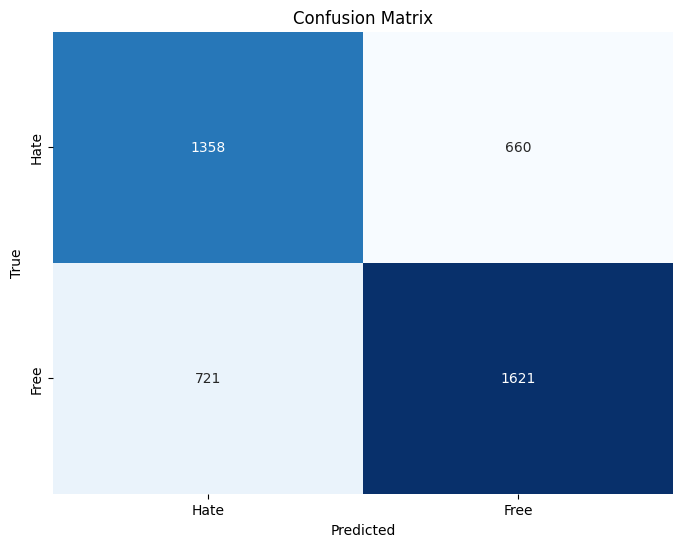

In [23]:
# Import necessary libraries for confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class labels

labels = ['Hate', 'Free']

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, predicted))

# Generate and plot the Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Plot the heatmap for the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Loss and Accuracy curves

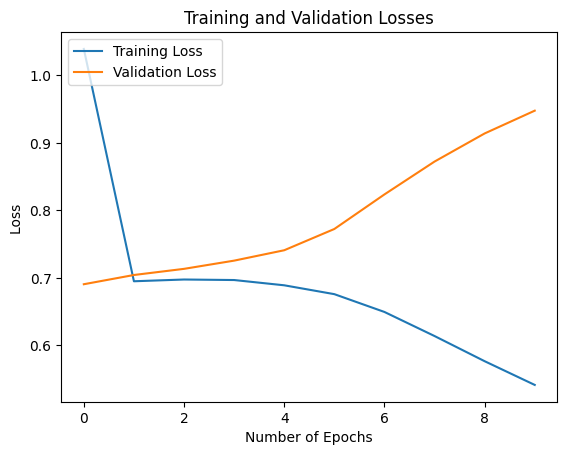

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.ylabel('Loss ')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.show()

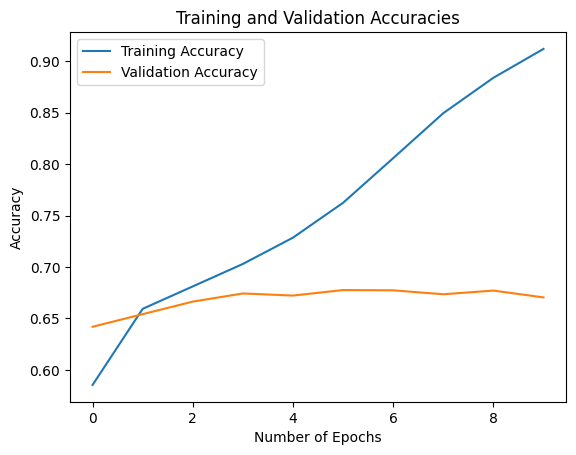

In [26]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.show() 

# End